# load necessary pacakges

In [1]:
import sys
import anndata
from scipy.sparse import csr_matrix

# the path to the scVI github repo https://github.com/YosefLab/scVI
# sys.path.append('/data/yosef2/users/chenling/scVI/')
sys.path.append('/home/angela/src/scVI_TSP/')
# the path to tabulasapiens github repo https://github.com/czbiohub/tabula-sapiens
# sys.path.append('/data/yosef2/users/chenling/tabula-sapiens/')
sys.path.append('/home/angela/sapiens/tabula-sapiens/')


from scvi.dataset import AnnDatasetFromAnnData
from utils.annotations_utils import *
from anndata import read_h5ad
import scanpy as sc

# if a model has been trained load pretrained model rather than retraining
retrain=False


/home/angela/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import matplotlib
%matplotlib inline

In [3]:
# data_path = '/data/yosef2/users/chenling/TabulaSapiensData/'
# model_path = '/data/yosef2/users/chenling/TabulaSapiens/scVImodels/'
# res_path = '/data/yosef2/users/chenling/TabulaSapiens/Combined'

data_path = '/mnt/ibm_lg/angela/sapiens/data/'
model_path = '/mnt/ibm_lg/angela/sapiens/data/scVI_models/'
res_path = '/mnt/ibm_lg/angela/sapiens/data/'

# if not os.path.exists(model_path):
#     os.mkdir(model_path)
# if not os.path.exists(model_path+'scanvi/'):
#     os.mkdir(model_path+'scanvi/')
# if not os.path.exists(res_path):
#     os.mkdir(res_path)

In [17]:
combined = read_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id_Jun28.h5ad')

In [49]:
combined = combined[~combined.obs['tissue'].isin(['Skin','Heart','Fat'])]
combined

View of AnnData object with n_obs × n_vars = 202655 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'notes', 'donor', 'smartseq2_sorted_population', '10X_replicate', '10X_sample', 'sequencer', 'sex', 'anatomical_position', 'tissue', 'smartseq2_well_seq', '10X_barcode', 'n_counts', 'n_genes', 'donor_tech', 'batch', 'donor_tech_tissue'
    var: 'feature_types-0-0', 'gene_symbol-0-0', 'ensembls-1', 'query-1', '_id-1', '_score-1-0', 'entrezgene-1', 'name-1-0', 'taxid-1', 'notfound-1', 'n_cells-1-0', 'gene_symbol-1-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'ensembls-1-0-1', 'query-1-0-1', '_id-1-0-1', '_score-1-0-1', 'entrezgene-1-0-1', 'name-1-0-1', 'taxid-1-0-1', 'notfound-1-0-1', 'n_cells-1-0-1', 'gene_symbol-1-0-1', '_score-1-1', 'name-1-1', 'n_cells-1-1', 'gene_symbol-1-1', 'n_cells'
    uns: 'neighbors', 'umap', 'donor_tech_colors', 'tissue_colors', 'd

In [51]:
combined.write_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id_Jun28_no-skin-heart-fat.h5ad')

In [52]:
set(combined.obs['tissue'])

{'Bladder',
 'Blood',
 'Bone_Marrow',
 'Kidney',
 'Large_Intestine',
 'Lung',
 'Lungneuron',
 'Lymph_Node',
 'Muscle',
 'Pancreas',
 'Small_Intestine',
 'Spleen',
 'Thymus',
 'Trachea',
 'Vasculature'}

In [53]:
sc.tl.umap(combined)

Trying to set attribute `.uns` of view, copying.


In [69]:
sum(combined[:,'ENSG00000081237.20'].X.todense()>0)

matrix([[76913]])

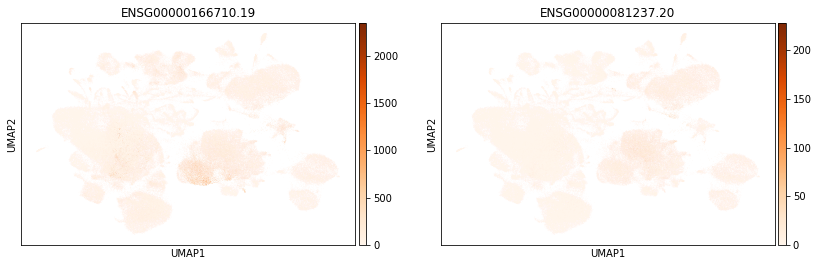

In [60]:
sc.pl.umap(combined,color=['ENSG00000166710.19','ENSG00000081237.20'],cmap='Oranges')

In [59]:
combined.var_names[combined.var_names.str.startswith('ENSG00000081237')]

Index(['ENSG00000081237.20'], dtype='object')

In [22]:
ss2_index = combined.obs.loc[combined.obs['method']=='smartseq2'].index
len(ss2_index)

12497

In [23]:
# txlen = pd.read_csv(data_path + 'homo.gencode.v30.annotation.ERCC92.iso_length.txt', delimiter='\t')

# combined.var['len'] = 0
# txlen = pd.read_csv(data_path + 'homo.gencode.v30.annotation.ERCC92.iso_length.txt', delimiter='\t')
# for x in np.unique(txlen['gene']):
#     isolen = txlen.loc[txlen['gene']==x,'length'].values.astype(int)
#     if x in combined.var.index:
#         combined.var.loc[x,'len'] = np.mean(isolen)

# combined.var.to_csv(data_path + 'combinedined/combined.var.csv')

In [24]:
var = pd.read_csv('ss2.var.csv',index_col=0)
assert np.sum(var.index == combined.var.index) == var.shape[0]
med_len = np.median(var['len'])

In [25]:
rand = np.arange(0, 8000,500)

In [26]:
temp = combined[combined.obs['method']=='smartseq2'].X[rand]

In [27]:
for i,x in enumerate(ss2_index):
#     print(i,x)
    a = np.asarray(combined[x].X.todense()).ravel()
    b = (a/var['len']*med_len).astype(int)
    combined[x,b[a>0].index].X = pd.DataFrame(b[a>0])

In [28]:
temp2 = combined[combined.obs['method']=='smartseq2'].X[rand]

In [29]:
for i in range(10):
    a = np.asarray(temp[i].todense()).ravel()
    b = np.asarray(temp2[i].todense()).ravel()
    assert (np.sum((a/var['len'].values*med_len).astype(int)==b)) == len(a)

In [30]:
combined.write_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id_Jun28.ss2_norm.h5ad')

In [ ]:
combined = sc.read_h5ad(data_path + 'Pilot1_Pilot2_filtered_ensembl_id.ss2_norm.h5ad')

In [31]:
donor_tech = combined.obs[['donor','method']].apply(lambda x:"_".join(x), axis=1)
combined.obs['donor_tech'] = donor_tech

In [32]:
def scVIdata_preprocess(combined, batch_col = 'Tissue Tech', label_col = 'scANVI Prediction By Organ'):
    tissue_tech_list = list(np.unique(combined.obs[batch_col]))
    batch_id = [tissue_tech_list.index(x) for x in combined.obs[batch_col]]
    combined.obs['batch'] = batch_id
    
    train_data = AnnDatasetFromAnnData(combined, batch_label='batch')
    labels = combined.obs[label_col]
    train_data.cell_types, train_data.labels = np.unique(labels, return_inverse=True)
    train_data.labels = train_data.labels.reshape(len(train_data.labels), 1)
    train_data.n_labels = len(train_data.cell_types)
    
    return train_data

# batch by donor and technology

In [33]:
combined.shape

(204082, 58870)

In [ ]:
combined = combined[combined.obs['method']=='10X'].copy()
combined = 

[2020-06-28 23:03:01,959] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-28 23:03:01,966] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-28 23:03:09,495] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-28 23:03:11,862] INFO - scvi.dataset.dataset | Downsampled from 204082 to 204082 cells


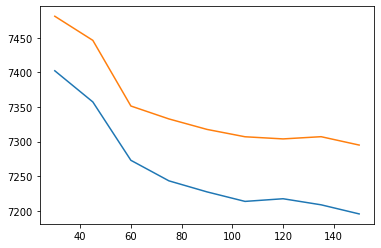

In [34]:
train_data = scVIdata_preprocess(combined, batch_col='donor_tech', label_col='tissue')

posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12_Jun28.all.donor_tech.50.3.ss2_norm.scVI.pkl', 
                               retrain=retrain, n_latent=50, n_layers=3)


In [35]:
latent = posterior.get_latent()
combined.obsm['X_scvi'] = latent[0]
sc.pp.neighbors(combined, n_neighbors=100, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech.100'] = combined.obsm['X_umap']
combined.obsm['X_scvi_donor_tech'] = combined.obsm['X_scvi']

In [36]:
# sc.pp.neighbors(combined, n_neighbors=500, n_pcs=30, use_rep="X_scvi")
# sc.tl.umap(combined)
# combinedined.obsm['UMAP_donor_tech.500'] = combined.obsm['X_umap']

In [37]:
# sc.pp.neighbors(combined, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
# sc.tl.umap(combined)
# combinedined.obsm['UMAP_donor_tech.50'] = combined.obsm['X_umap']

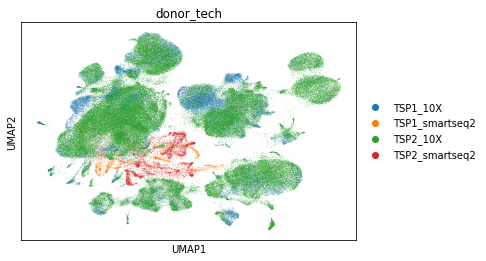

In [47]:
sc.pl.umap(combined, color=['donor_tech'])

In [ ]:
pilot2 = read_h5ad(data_path + 'Pilot2/Pilot2.filtered.h5ad')

In [ ]:
pilot2.obsm

In [ ]:
sc.pl.umap(combined, color=['donor_tech'])

In [ ]:
combined.write_h5ad(data_path + 'combined/combined.pilot_sequencer.new_params.h5ad')

# batch by donor and technology and tissue

In [39]:
donor_tech_tissue = combined.obs[['donor','method','tissue']].apply(lambda x:"_".join(x), axis=1)
combined.obs['donor_tech_tissue'] = donor_tech_tissue

[2020-06-29 00:19:01,619] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-06-29 00:19:01,627] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-06-29 00:19:12,391] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-06-29 00:19:13,897] INFO - scvi.dataset.dataset | Downsampled from 204082 to 204082 cells


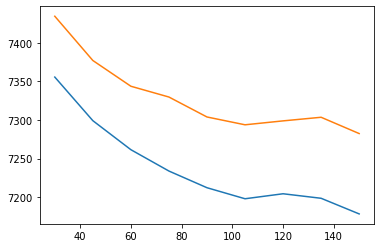

In [40]:
train_data = scVIdata_preprocess(combined, batch_col='donor_tech_tissue', label_col='tissue')

posterior = get_scvi_posterior(train_data, 
                               model_path+'Pilot12_Jun28.all.donor_tech_tissue.50.3.ss2_norm.scVI.pkl', 
                               retrain=retrain, n_latent=50, n_layers=3)


In [41]:
set(combined.obs['donor_tech_tissue'])

{'TSP1_10X_Bladder',
 'TSP1_10X_Blood',
 'TSP1_10X_Lung',
 'TSP1_10X_Muscle',
 'TSP1_10X_Pancreas',
 'TSP1_smartseq2_Bladder',
 'TSP1_smartseq2_Blood',
 'TSP1_smartseq2_Lung',
 'TSP1_smartseq2_Muscle',
 'TSP1_smartseq2_Pancreas',
 'TSP2_10X_Bladder',
 'TSP2_10X_Blood',
 'TSP2_10X_Bone_Marrow',
 'TSP2_10X_Fat',
 'TSP2_10X_Heart',
 'TSP2_10X_Kidney',
 'TSP2_10X_Large_Intestine',
 'TSP2_10X_Lung',
 'TSP2_10X_Lymph_Node',
 'TSP2_10X_Muscle',
 'TSP2_10X_Skin',
 'TSP2_10X_Small_Intestine',
 'TSP2_10X_Spleen',
 'TSP2_10X_Thymus',
 'TSP2_10X_Trachea',
 'TSP2_10X_Vasculature',
 'TSP2_smartseq2_Bladder',
 'TSP2_smartseq2_Blood',
 'TSP2_smartseq2_Bone_Marrow',
 'TSP2_smartseq2_Kidney',
 'TSP2_smartseq2_Large_Intestine',
 'TSP2_smartseq2_Lung',
 'TSP2_smartseq2_Lungneuron',
 'TSP2_smartseq2_Lymph_Node',
 'TSP2_smartseq2_Muscle',
 'TSP2_smartseq2_Skin',
 'TSP2_smartseq2_Small_Intestine',
 'TSP2_smartseq2_Spleen',
 'TSP2_smartseq2_Thymus',
 'TSP2_smartseq2_Trachea',
 'TSP2_smartseq2_Vasculature'}

In [42]:
len(np.unique(train_data.batch_indices)), len(set(combined.obs['donor_tech_tissue']))

(41, 41)

In [43]:
latent = posterior.get_latent()
combined.obsm['X_scvi_donor_tech_tissue'] = latent[0]
sc.pp.neighbors(combined, n_neighbors=100, n_pcs=30, use_rep="X_scvi_donor_tech_tissue")
sc.tl.umap(combined)
combined.obsm['UMAP_donor_tech_tissue.100'] = combined.obsm['X_umap']

In [44]:
# sc.pp.neighbors(combined, n_neighbors=500, n_pcs=30, use_rep="X_scvi")
# sc.tl.umap(combined)
# combined.obsm['UMAP_donor_tech_tissue.500'] = combined.obsm['X_umap']

# sc.pp.neighbors(combined, n_neighbors=50, n_pcs=30, use_rep="X_scvi")
# sc.tl.umap(combined)
# combined.obsm['UMAP_donor_tech_tissue.50'] = combined.obsm['X_umap']

... storing 'donor_tech_tissue' as categorical


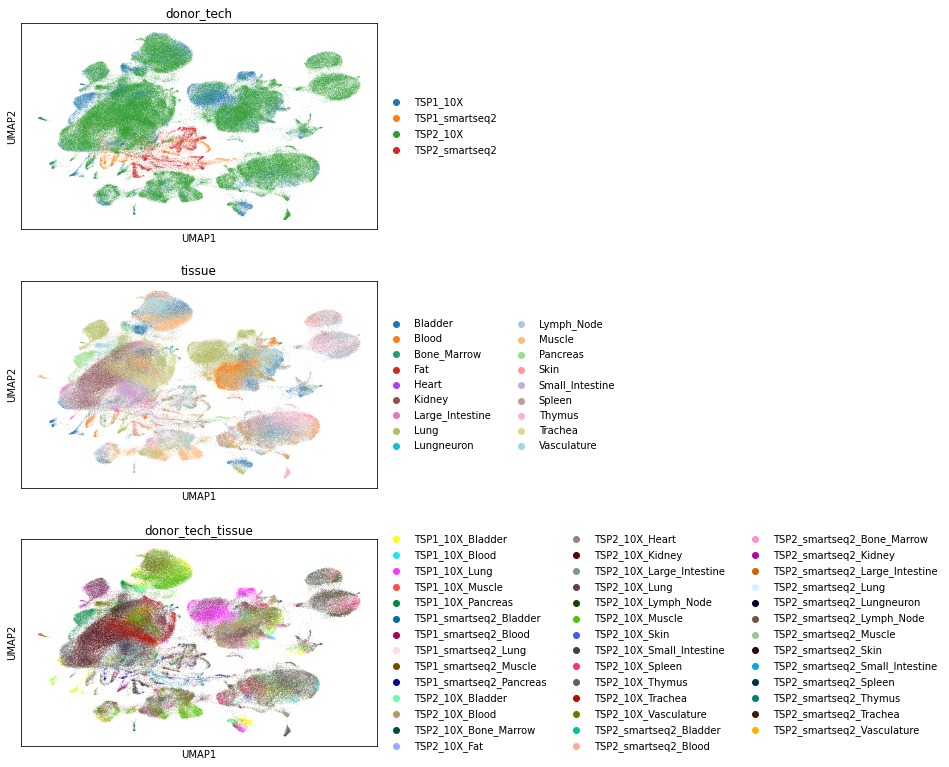

In [45]:
sc.pl.umap(combined, color=['donor_tech','tissue','donor_tech_tissue'],ncols=1)

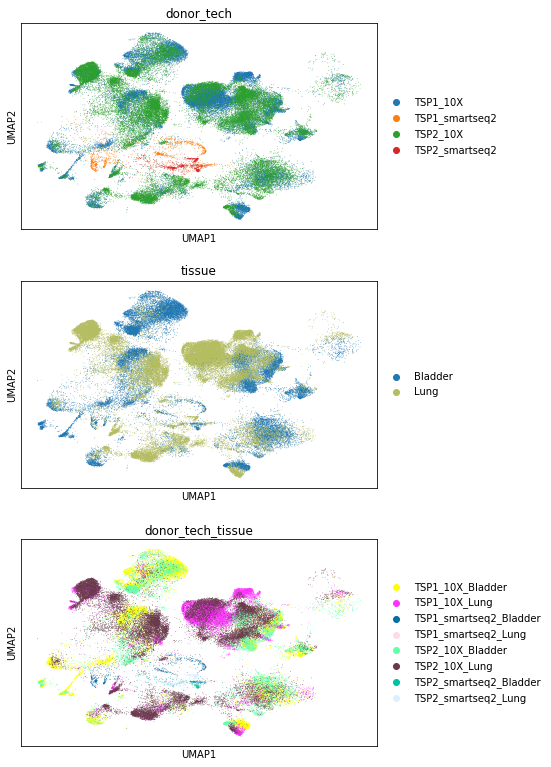

In [46]:
sc.pl.umap(combined[combined.obs['tissue'].isin(['Lung','Bladder'])], 
           color=['donor_tech','tissue','donor_tech_tissue',],ncols=1)

In [ ]:
meta = pd.read_csv(data_path+'combined.meta.ann.csv', index_col=0, dtype=str)
assert np.sum(combined.obs.index == meta.index) == len(meta.index)
combined.obs = meta

In [ ]:
combined.write_h5ad(data_path + 'combined.pilot_sequencer.ann.h5ad')

In [20]:
adata = combined.copy()
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 204082 × 58870 
    obs: '10X_run', 'smartseq2_barcode', 'smartseq2_library_plate', 'smartseq2_sorting_direction', 'smartseq2_sort_order', 'smartseq2_cDNA_Plate', 'cell_id', 'method', 'notes', 'donor', 'smartseq2_sorted_population', '10X_replicate', '10X_sample', 'sequencer', 'sex', 'anatomical_position', 'tissue', 'smartseq2_well_seq', '10X_barcode', 'n_counts', 'n_genes'
    var: 'feature_types-0-0', 'gene_symbol-0-0', 'ensembls-1', 'query-1', '_id-1', '_score-1-0', 'entrezgene-1', 'name-1-0', 'taxid-1', 'notfound-1', 'n_cells-1-0', 'gene_symbol-1-0', 'feature_types-0-0-1', 'gene_symbol-0-0-1', 'ensembls-1-0-1', 'query-1-0-1', '_id-1-0-1', '_score-1-0-1', 'entrezgene-1-0-1', 'name-1-0-1', 'taxid-1-0-1', 'notfound-1-0-1', 'n_cells-1-0-1', 'gene_symbol-1-0-1', '_score-1-1', 'name-1-1', 'n_cells-1-1', 'gene_symbol-1-1', 'n_cells'
    layers: 'counts'

In [ ]:
combined

In [ ]:
adata.X[100:110,100:110].todense()

In [ ]:
adata.obs

normalization & scaling
pca


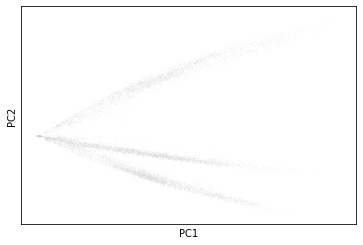

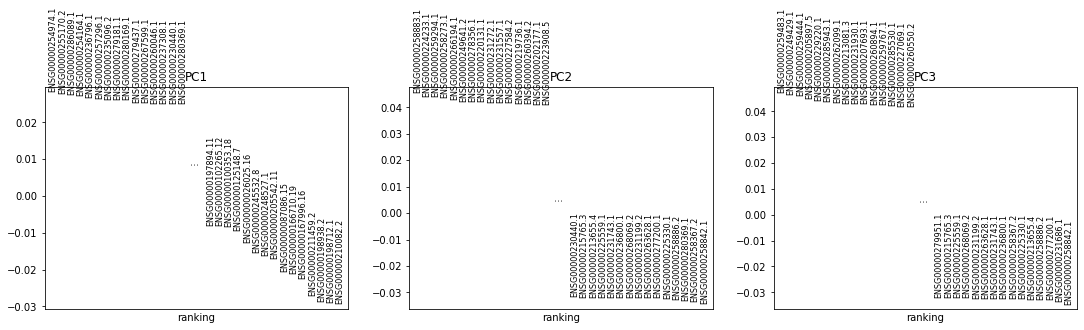

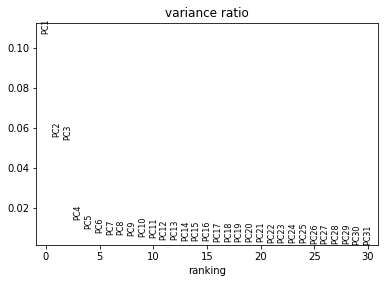

neighs
umap computing


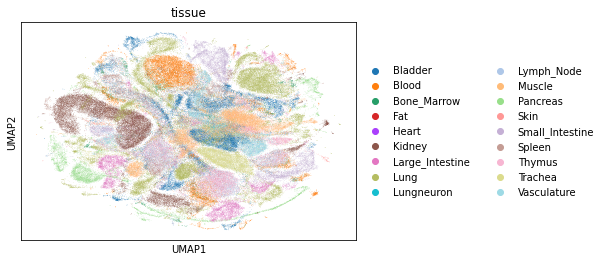

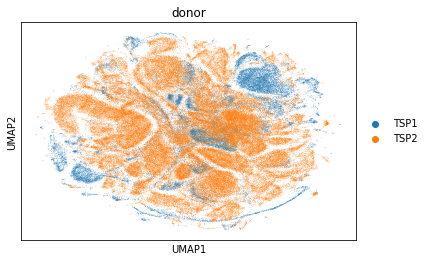

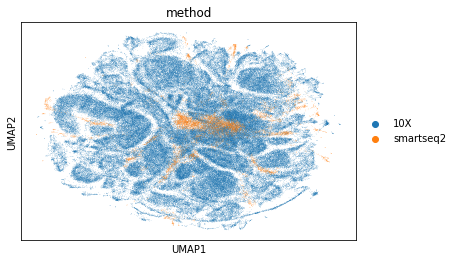

In [21]:
adata.X = adata.layers["counts"].copy()
print('normalization & scaling')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                          min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                          log=True, copy=True)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10, zero_center=False)
# adata.uns['tissue_colors'] = list(tissue_color_dict.values())


print('pca')
sc.tl.pca(adata,svd_solver='arpack')
sc.pl.pca_overview(adata)


print('neighs')
# sc.pp.neighbors(adata)
sc.external.pp.bbknn(adata, 
                      batch_key='method', 
                      approx=True, metric='angular',
                      n_pcs=50, trim=None, n_trees=10, 
                      use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=1)

print('umap computing')
sc.tl.umap(adata,n_components=2)
# adata.obs['tissue_FACS_droplet'] = adata.obs['tissue'].copy()
# adata.obs.loc[adata.obs['tissue'] == 'Heart_and_Aorta','tissue'] = 'Heart'
# adata.obs['tissue'] = adata.obs['tissue'].astype(str)
# adata.uns['age_colors'] = list(age_color_dict.values())
# adata.uns['tissue_colors'] = list(tissue_color_dict.values())
# adata.uns['method_colors'] = list(methods_color_dict.values())
sc.pl.umap(adata,color='tissue')#,projection='3d',save='_maca_facs_3d_tissue.pdf')
sc.pl.umap(adata,color='donor')#,projection='3d', save='_maca_facs_3d_age.pdf')
sc.pl.umap(adata,color='method')#,projection='3d', save='_maca_facs_3d_age.pdf')

# print('clustering')
# sc.tl.louvain(adata)#, resolution = 5)
# sc.tl.leiden(adata)#, resolution = 5)

# sc.pl.umap(adata,color=['louvain'], legend_loc='on data')